# Water Observations from Space (WOfS)
Using Geoscience Australia [WOfS algorithm](https://github.com/GeoscienceAustralia/wofs/blob/master/wofs/virtualproduct.py).

<a id="top"></a>
# Table of contents
* [Data parameters - Lake Tempe ](#dec36175-7220-4d9a-99ad-f8ccdbeacad2)
* [Set proxy parameters to access data locally](#01280eb5-c8e5-4f69-91a2-3fde95230595)
* [Start a dask cluster to distribute operations](#7e43197c-a282-4d33-b262-914669a89d38)
* [Import dependencies and initialise datacube](#65f39dce-ad83-447c-ac07-e561a18c4548)
* [Display the region of interest](#60cf4081-bc0a-4926-b96a-7d578002938b)
* [Display the DSM](#b0c5a987-6ae0-4103-ae99-17a1992bb8ec)
* [Load the data](#68320ce6-0677-4246-8299-29e14db692f5)
* [Classify WOFS](#b9011449-595d-4ab8-ab77-60f4d9773442)
* [Temporal analysis](#6f9f3501-eedd-49d9-8139-089991535b9c)

## <span id="dec36175-7220-4d9a-99ad-f8ccdbeacad2">Data parameters - Lake Tempe [&#9652;](#top)</span>
For the Digital Surface Model (DSM): we use the [DEM from Indonesia Geospasial](https://www.indonesia-geospasial.com/2020/01/download-dem-srtm-30-meter-se-indonesia.html)

**If you don't have it yet, get the DEM:**
1. Download `33 - DEM SRTM 30m Provinsi Papua Barat` to your computer: `33. Provinsi Sulawesi Selatan.zip`
2. Drag this file into your JupyterLab Home directory
3. In JupyterLab: `File --> New --> Terminal` and run the following commands:
```
mkdir dems
mv "33. Provinsi Sulawesi Selatan.zip" dems
cd dems
unzip "33. Provinsi Sulawesi Selatan.zip"
exit
```

In [1]:
product = "landsat8_c2l2_sr"
longitude = (119.8242517, 120.0350519)
latitude = (-4.2013799, -3.9445384)
time = ('2020-01-01', '2021-01-31')
output_crs = "EPSG:32650"
resolution = (30, -30)

DSM_PATH = "/home/jovyan/dems/33. Provinsi Sulawesi Selatan/DEM SRTM 30M SULAWESI SELATAN.tif"

## <span id="01280eb5-c8e5-4f69-91a2-3fde95230595">Set proxy parameters to access data locally [&#9652;](#top)</span>

In [2]:
from os import environ

environ["AWS_HTTPS"] = "NO"
environ["GDAL_HTTP_PROXY"] = "easi-caching-proxy.caching-proxy:80"
print(f'Will use caching proxy at: {environ.get("GDAL_HTTP_PROXY")}')

Will use caching proxy at: easi-caching-proxy.caching-proxy:80


## <span id="7e43197c-a282-4d33-b262-914669a89d38">Start a dask cluster to distribute operations [&#9652;](#top)</span>
The dashboard url allows us to monitor things.

In [3]:
from os import environ
from urllib.parse import urlparse
from dask.distributed import Client, LocalCluster
from IPython.core.display import HTML

cluster = LocalCluster(scheduler_port=0, dashboard_address=":0")
client = Client(cluster)
display(cluster)
if cluster:
    port = urlparse(cluster.dashboard_link).port
    dashboard_url = (
        f'https://hub.sg-dev.easi-eo.solutions/'
        f'{environ["JUPYTERHUB_SERVICE_PREFIX"]}proxy/{port}/status'
    )
    display(HTML(f'Dashboard: <a href={dashboard_url}>{dashboard_url}</a>'))

## <span id="65f39dce-ad83-447c-ac07-e561a18c4548">Import dependencies and initialise datacube [&#9652;](#top)</span>

Clone [hub-notebooks](https://csiro-easi@dev.azure.com/csiro-easi/easi-hub-public/_git/hub-notebooks) if needed. It is used for `display_map` only

In [4]:
!if [ ! -d ../../hub-notebooks ] ; then git clone https://csiro-easi@dev.azure.com/csiro-easi/easi-hub-public/_git/hub-notebooks ../../hub-notebooks ; fi

In [5]:
import sys
sys.path.insert(0, "../../hub-notebooks/scripts")

import xarray as xr

from app_utils import display_map
from wofs.virtualproduct import WOfSClassifier

In [6]:
from datacube import Datacube
from datacube.utils.aws import configure_s3_access

configure_s3_access(
    aws_unsigned=False, 
    requester_pays=True, 
    client=client, 
);

dc = Datacube()

In [7]:
# Display available products
products_info = dc.list_products()
products_info

,name,description,license,default_crs,default_resolution
name,,,,,
landsat5_c2l2_sr,landsat5_c2l2_sr,Landsat 5 Collection 2 Level-2 Surface Reflect...,None,None,None
landsat7_c2l2_sr,landsat7_c2l2_sr,Landsat 7 USGS Collection 2 Surface Reflectanc...,None,None,None
landsat8_c2l2_sr,landsat8_c2l2_sr,"Landsat 8 Collection 2 Surface Reflectance, pr...",None,None,None
s2_l2a,s2_l2a,"Sentinel-2a and Sentinel-2b imagery, processed...",None,None,None
usgs_aws_ls5c2_sr,usgs_aws_ls5c2_sr,Landsat 5 USGS Collection 2 Surface Reflectanc...,None,None,None
usgs_aws_ls7c2_sr,usgs_aws_ls7c2_sr,Landsat 7 USGS Collection 2 Surface Reflectanc...,None,None,None
usgs_aws_ls8c2_sr,usgs_aws_ls8c2_sr,Landsat 8 USGS Collection 2 Surface Reflectanc...,None,None,None


## <span id="60cf4081-bc0a-4926-b96a-7d578002938b">Display the region of interest [&#9652;](#top)</span>

In [8]:
display_map(x=longitude, y=latitude)

## <span id="b0c5a987-6ae0-4103-ae99-17a1992bb8ec">Display the DSM [&#9652;](#top)</span>

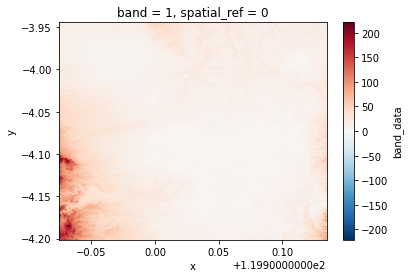

In [9]:
dsm = xr.open_dataset(DSM_PATH, engine="rasterio")
bd = dsm.band_data
roi = (longitude[0] <= bd.x) & (bd.x <= longitude[1]) & (latitude[0] <= bd.y) & (bd.y <= latitude[1])
tempe_dsm = bd.where(roi, drop=True)
tempe_dsm.plot();

## <span id="68320ce6-0677-4246-8299-29e14db692f5">Load the data [&#9652;](#top)</span>

In [10]:
measurements = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']
data = dc.load(
    product=product,
    longitude=longitude,
    latitude=latitude,
    time=time,
    output_crs=output_crs,
    resolution=resolution,
    measurements=measurements,
    dask_chunks={'time': 1},
)
data

<xarray.Dataset>
Dimensions:      (time: 21, y: 951, x: 785)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-09T02:10:26.574371 ... 2021-01...
  * y            (y) float64 -4.65e+05 -4.65e+05 ... -4.366e+05 -4.365e+05
  * x            (x) float64 8.371e+05 8.37e+05 8.37e+05 ... 8.136e+05 8.136e+05
    spatial_ref  int32 32650
Data variables:
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 951, 785), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 951, 785), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 951, 785), meta=np.ndarray>
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 951, 785), meta=np.ndarray>
    swir1        (time, y, x) uint16 dask.array<chunksize=(1, 951, 785), meta=np.ndarray>
    swir2        (time, y, x) uint16 dask.array<chunksize=(1, 951, 785), meta=np.ndarray>
    pixel_qa     (time, y, x) uint16 dask.array<chunksize=(1, 951, 785), meta=np.ndarray>
Attributes:
    crs:           EPSG:32650
    grid_mapping:  spatial_ref

### Rename bands as needed by the WOFS classifier

In [11]:
data = data.rename({
    "blue": "nbart_blue",
    "green": "nbart_green",
    "red": "nbart_red",
    "nir": "nbart_nir",
    "swir1": "nbart_swir_1",
    "swir2": "nbart_swir_2",
    "pixel_qa": "fmask",
})
data

<xarray.Dataset>
Dimensions:       (time: 21, y: 951, x: 785)
Coordinates:
  * time          (time) datetime64[ns] 2020-01-09T02:10:26.574371 ... 2021-0...
  * y             (y) float64 -4.65e+05 -4.65e+05 ... -4.366e+05 -4.365e+05
  * x             (x) float64 8.371e+05 8.37e+05 ... 8.136e+05 8.136e+05
    spatial_ref   int32 32650
Data variables:
    nbart_blue    (time, y, x) uint16 dask.array<chunksize=(1, 951, 785), meta=np.ndarray>
    nbart_green   (time, y, x) uint16 dask.array<chunksize=(1, 951, 785), meta=np.ndarray>
    nbart_red     (time, y, x) uint16 dask.array<chunksize=(1, 951, 785), meta=np.ndarray>
    nbart_nir     (time, y, x) uint16 dask.array<chunksize=(1, 951, 785), meta=np.ndarray>
    nbart_swir_1  (time, y, x) uint16 dask.array<chunksize=(1, 951, 785), meta=np.ndarray>
    nbart_swir_2  (time, y, x) uint16 dask.array<chunksize=(1, 951, 785), meta=np.ndarray>
    fmask         (time, y, x) uint16 dask.array<chunksize=(1, 951, 785), meta=np.ndarray>
Attributes:
    crs:           EPSG:32650
    grid_mapping:  spatial_ref

## <span id="b9011449-595d-4ab8-ab77-60f4d9773442">Classify WOFS [&#9652;](#top)</span>

In [12]:
transform = WOfSClassifier(c2_scaling=True, dsm_path=DSM_PATH)
# Compute the WOF layer
wofl = transform.compute(data)
wofl

<xarray.Dataset>
Dimensions:      (y: 951, x: 785, time: 21)
Coordinates:
  * y            (y) float64 -4.65e+05 -4.65e+05 ... -4.366e+05 -4.365e+05
  * x            (x) float64 8.371e+05 8.37e+05 8.37e+05 ... 8.136e+05 8.136e+05
  * time         (time) datetime64[ns] 2020-01-09T02:10:26.574371 ... 2021-01...
    spatial_ref  int32 32650
Data variables:
    water        (time, y, x) uint8 dask.array<chunksize=(1, 951, 785), meta=np.ndarray>
Attributes:
    crs:      EPSG:32650

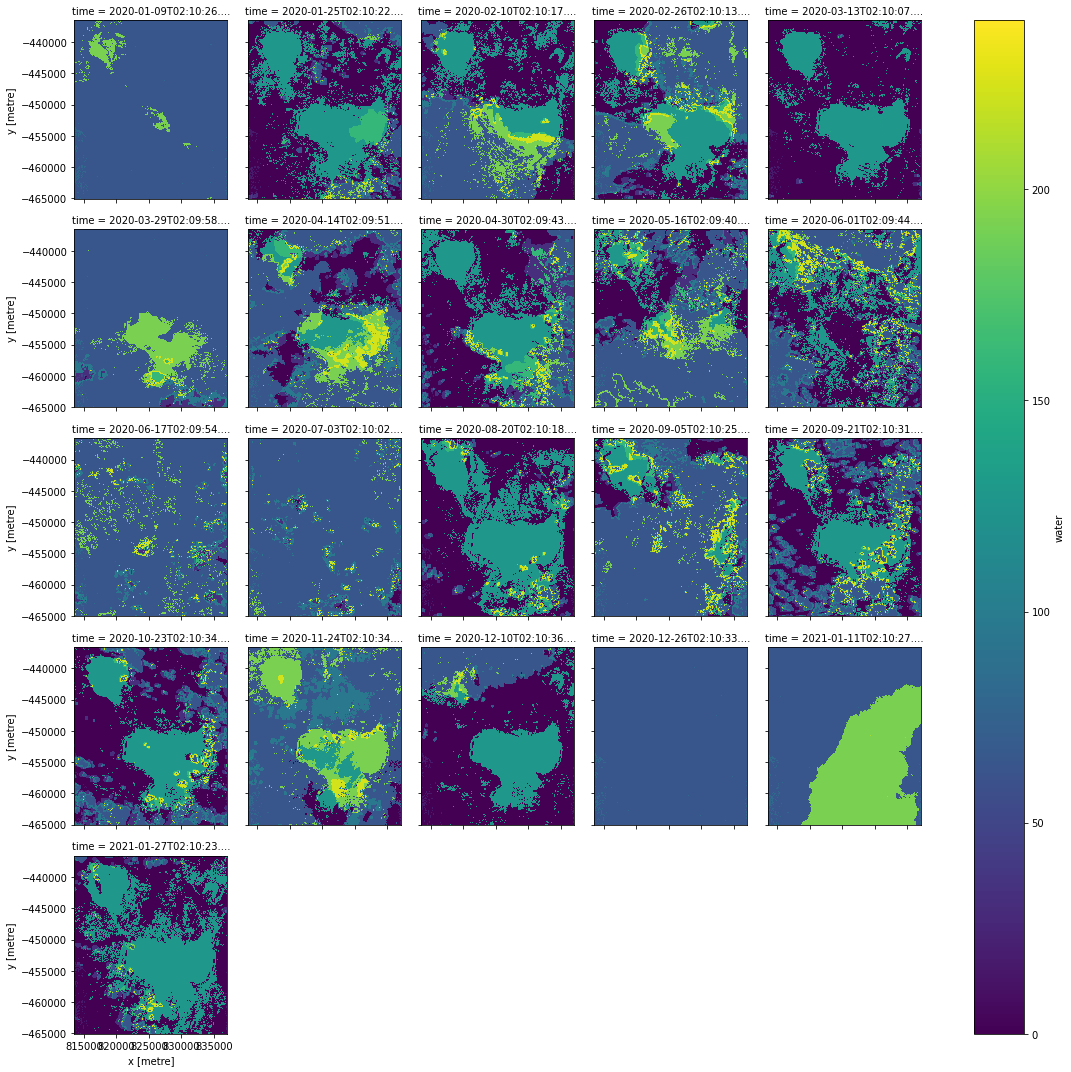

In [13]:
wofl.water.plot(col="time", col_wrap=5);

## <span id="6f9f3501-eedd-49d9-8139-089991535b9c">Temporal analysis [&#9652;](#top)</span>
Based on the [CEOS Notebook](https://github.com/ceos-seo/data_cube_notebooks/blob/master/notebooks/water/detection/water_detection_with_wofs.ipynb). **This is not fully tested yet and may change**

With all of the pixels classified as either water/non-water, let's perform a time series analysis over our derived water class. The function, *perform_timeseries_analysis*, takes in a dataset of 3 dimensions (time, latitude, and longitude), then sums the values of each pixel over time (# water). It also keeps track of the number of clear observations we have at each pixel (#clear). We can then normalise each pixel to determine areas at risk of flooding. The normalisation calculation is simply:

$$normalised\_water\_observations = \dfrac{total\_water\_observations}{total\_clear\_observations}$$

The output each of the three calculations (# water, # clear, "normalised water" - or "% water") can be seen below.

Clone [data_cube_utilities](https://github.com/ceos-seo/data_cube_utilities.git) and [data_cube_notebooks](https://github.com/ceos-seo/data_cube_notebooks.git) if needed.

In [14]:
!if [ ! -d ../../data_cube_utilities ] ; then git clone https://github.com/ceos-seo/data_cube_utilities.git ../../data_cube_utilities ; fi
!if [ ! -d ../../data_cube_notebooks ] ; then git clone https://github.com/ceos-seo/data_cube_notebooks.gitb ../../data_cube_notebooks ; fi

In [15]:
sys.path.insert(0, "../../data_cube_utilities")
sys.path.insert(0, "../../data_cube_notebooks/notebooks")

import matplotlib.pyplot as plt

from data_cube_utilities.dc_utilities import perform_timeseries_analysis
import dc_au_colormaps

In [16]:
wofl2 = wofl.rename({"x": "longitude", "y": "latitude"})
time_series = perform_timeseries_analysis(wofl2, 'water')

### Normalised water frequency according to WOfS

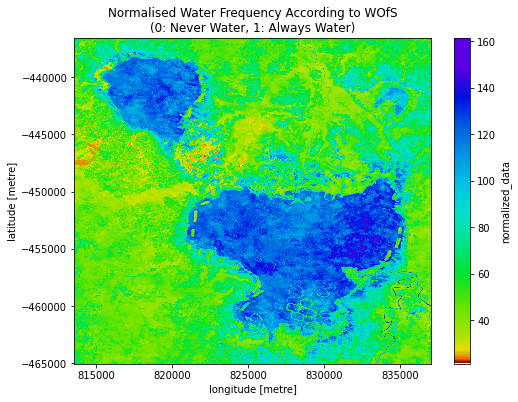

In [17]:
plt.figure(figsize=(8, 6))
time_series.normalized_data.plot(cmap='dc_au_WaterSummary')
plt.title('Normalised Water Frequency According to WOfS\n(0: Never Water, 1: Always Water)')
plt.show()

### Total clear water times according to WOfS

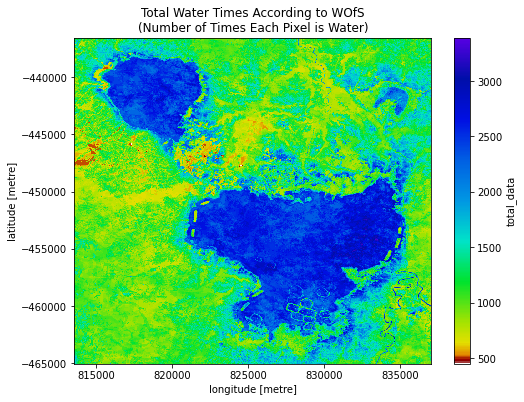

In [18]:
plt.figure(figsize=(8, 6))
time_series.total_data.plot(cmap='dc_au_WaterObservations')
plt.title('Total Water Times According to WOfS\n(Number of Times Each Pixel is Water)')
plt.show()

### Total clear times

This one needs to be further checked as the CEOS algorithm may not be compatible with our WOfS above.

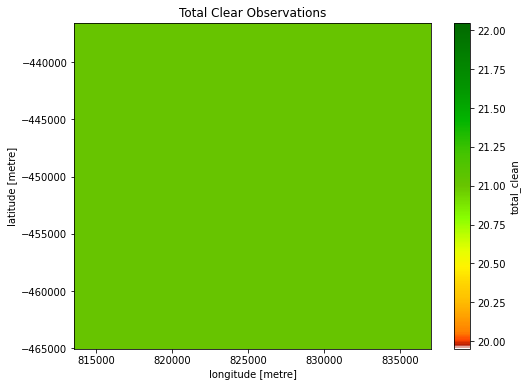

In [19]:
plt.figure(figsize=(8, 6))
time_series.total_clean.plot(cmap='dc_au_ClearObservations')
plt.title('Total Clear Observations')
plt.show()